# Chapter 3: Classification

## 1. Import Data

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([5, 0, 4, ..., 4, 5, 6], dtype=int8))

In [4]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70,000 images and each image has 784 features (28 x 28 pixels)

In [5]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

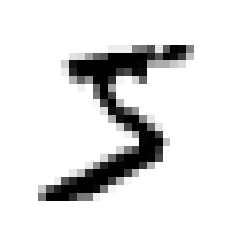

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

5

## 2. Train-Test-Split

In [8]:
# since training set is already shuffled for us
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3. Training a Binary Classifier

Try to only identify one digit. This is a binary classifier. Whether it is 5 or not 5

In [9]:
y_train_5 = (y_train == 5) # True for all 5s and False for all othe digits
y_test_5 = (y_test == 5)

SGD classifier has the advantage of being capable of handling very large datasets efficiently. This is because SGD deals with training instances independently, one at a time. The SGDClassifier relies on randomness during training. If you want reproducible results, you should set the random_state parameter

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
# detect images of number 5
sgd_clf.predict([some_digit])

array([ True])

## 4. Performance Measures

### 4.1 Measuring Accuracy Using Cross-Validation

Implementing CV from scratch

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/ len(y_pred))

0.95035
0.96035
0.9604


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Compare results with a base classifier

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Since there is only about 10% of the images that are 5s, if you always guess that an image is not a 5, you will right 90% of the time. This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with a very skewed dataset.

### 4.2 Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict 

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Instead of returning the evaluation scores, it returns the predictions made on each test fold

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [22]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [23]:
y_train_5

array([ True, False, False, ...,  True, False, False])

### 4.3 Precision and Recall

Have to see which one you care about more. FP (precision) or FN (recall)

In [26]:
from sklearn.metrics import precision_score, recall_score

print("Precision Score:", precision_score(y_train_5, y_train_pred))
print("Recall Score", recall_score(y_train_5, y_train_pred))

Precision Score: 0.8370879772350012
Recall Score 0.6511713705958311


In [27]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The higher the threshold, the lower the recall but higher the precision

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How to decide which threshold to use? Use the cross_val_predict function to get the scores of all instances in the training set

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [35]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [48]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

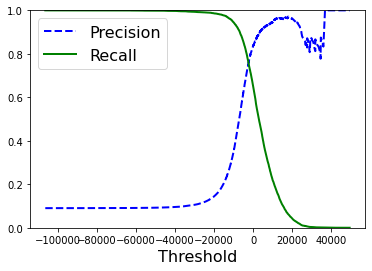

In [49]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

How to make predictions using threshold?

In [50]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

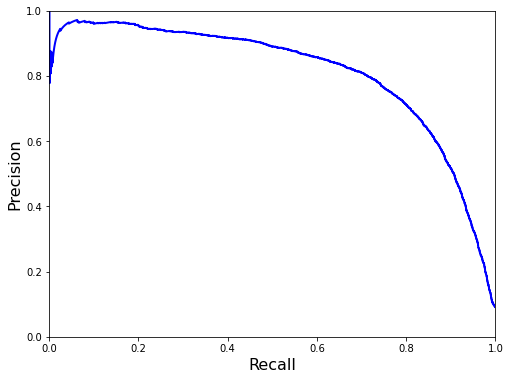

In [52]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

However, a high-precision classifier is not very useful if its recall is too low

### 4.4 ROC Curve

ROC curve is another common tool used with binary classifiers. It is similar to precision/recall curve but instead of precision vs recall, it plots the TPR (Recall/Sensitivity) against FPR (1 - TNR = 1 - specificity)

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, threholds = roc_curve(y_train_5, y_scores)

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


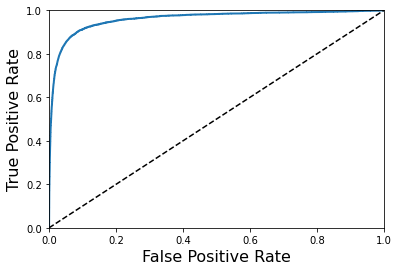

In [54]:
plot_roc_curve(fpr, tpr)
plt.show()

The dotted line represents the ROC curve of a purely random classifier. A good classifier stays as far away from that line as possible (top-left corner)

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have AUC=1, whereas purely random classifier will have AUC=0.5

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Use PR curve when the positive class is rare or when you care more about the FP than FN. Otherwise, use ROC.

In [56]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [57]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [58]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


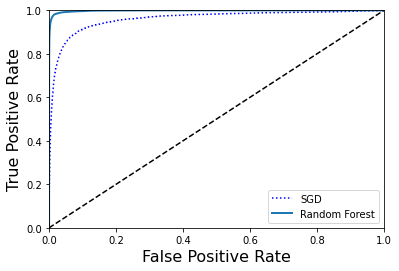

In [59]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

Comparing the ROC curves, the random forest classifier is superior to the SGD classifier because its ROC curve is much closer to top-left corner and it has a greater AUC

In [60]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [62]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [63]:
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [67]:
threshold = 0.5
y_scores_forest_pred = (y_scores_forest > threshold)

In [68]:
precision_score(y_train_5, y_scores_forest_pred)

0.9905083315756169

In [69]:
recall_score(y_train_5, y_scores_forest_pred)

0.8662608374838591